# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Assignment 6: Demand Forecasting

## Learning Objectives

At the end of the experiment, you will be able to :

* perform EDA and analyze the feature importance of sales data
* prepare the data for forecasting task
* solve the problem of Demand Planning Optimization
* implement ARIMA model to forecast the demands of a sales

## Information

Sales forecasting is an approach retailers use to anticipate future sales by analyzing past sales, identifying trends, and projecting data into the future. The simplest version of a sales forecast will look at sales in Store A during last year, assume a continuation of some multi-year trend for Store A (e.g. some percentage of growth or decline in sales), and project forward to predict sales in Store A this year.

Sales forecasting has been the standard approach to retailing from the beginning of the industry itself.

Although modern retailers have more data than ever (as well as new tools and business intelligence dashboards), and can easily leverage more advanced and accurate forms of forecasting, sales-based forecasting is still the backbone of most retail organizations.

some benefits of having an accurate sales forecast

* Improved decision-making about the future
* Reduction of sales pipeline and forecast risks
* Alignment of sales quotas and revenue expectations
* Reduction of time spent planning territory coverage and setting quota assignments
* Benchmarks that can be used to assess trends in the future
* Ability to focus a sales team on high-revenue, high-profit sales pipeline  opportunities, resulting in improved win rates


This Demand optimization can reduce operational costs by:

**Inventory Optimization:** matching store inventory with actual needs to reduce storage space needed (Rental Costs)

**Replenishment Optimization:** optimizing replenishment quantity per order to minimize the number of replenishments between warehouse and stores (Warehousing & Transportation Costs)


## Dataset

Store Item Demand Forecasting dataset consists of 5 years of store-item sales data from the year 2013 to 2017. It contains sales for 50 different items at 10 different stores with 913000 observations and 4 columns Date Store, item, sales.

Attributes information:

**Date:** Date starting from 2013 to 2017

**Store:** Store indicating with a number

**Item:** Item  in a store

**Sales:** No.of sales 

### Setup Steps:

### Import required packages 

In [4]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy import stats
from scipy.stats import normaltest
import pmdarima as pm

### Load the data

In [5]:
dataset  =  pd.read_csv('Store_Item_demand_forecast.csv')
dataset.head(), dataset.shape

(         date  store  item  sales
 0  2013-01-01      1     1     13
 1  2013-01-02      1     1     11
 2  2013-01-03      1     1     14
 3  2013-01-04      1     1     13
 4  2013-01-05      1     1     10, (913000, 4))

### Data Pre-processing

* Convert the Date column and separate Date, Month and Year columns to add more features including day of year,  day of week and week of year.

* Create a new feature $Day^{year}$ using Day of year and year



In [6]:
# DATES FEATURES
def date_features(df):
    # Date Features
    dataset = df
    df['date'] = pd.to_datetime(dataset['date'])
    df['year'] = dataset.date.dt.year
    df['month'] = dataset.date.dt.month
    df['day'] = dataset.date.dt.day
    df['dayofyear'] = dataset.date.dt.dayofyear
    df['dayofweek'] = dataset.date.dt.dayofweek
    df['weekofyear'] = dataset.date.dt.weekofyear
    
    # Additionnal Data Features
    df['day^year'] = np.log((np.log(dataset['dayofyear'] + 1)) ** (dataset['year'] - 2000))
    
    # Drop date
    df.drop('date', axis=1, inplace=True)
    return df

In [7]:
# Dates Features for Train
train = date_features(dataset)
train.head()

,store,item,sales,year,month,day,dayofyear,dayofweek,weekofyear,day^year
0,1,1,13,2013,1,1,1,1,1,-4.764668
1,1,1,11,2013,1,2,2,2,1,1.222622
2,1,1,14,2013,1,3,3,3,1,4.246245
3,1,1,13,2013,1,4,4,4,1,6.186505
4,1,1,10,2013,1,5,5,5,1,7.581575


### ARIMA Analysis

#### Decomposition

Time series data can be broken down into four core components: the average value, a trend (i.e. an increasing mean), seasonality (i.e. a repeating cyclical pattern), and a residual (random noise). Trends and seasonality are not always present in time dependent data. The residual is what’s left over after trends and seasonality are removed. Time series models assume that the data is stationary and only the residual component satisfies the conditions for stationarity.

Python’s statsmodels library has a method for time series decomposition called `seasonal_decompose()`.

* Apply decomposition and plot the trend, seasonality and residual

To know more about `seasonal_decompose()`function click [here](https://www.statsmodels.org/devel/generated/statsmodels.tsa.seasonal.seasonal_decompose.html)

In [8]:
sample=train['sales']

<Figure size 432x288 with 0 Axes>

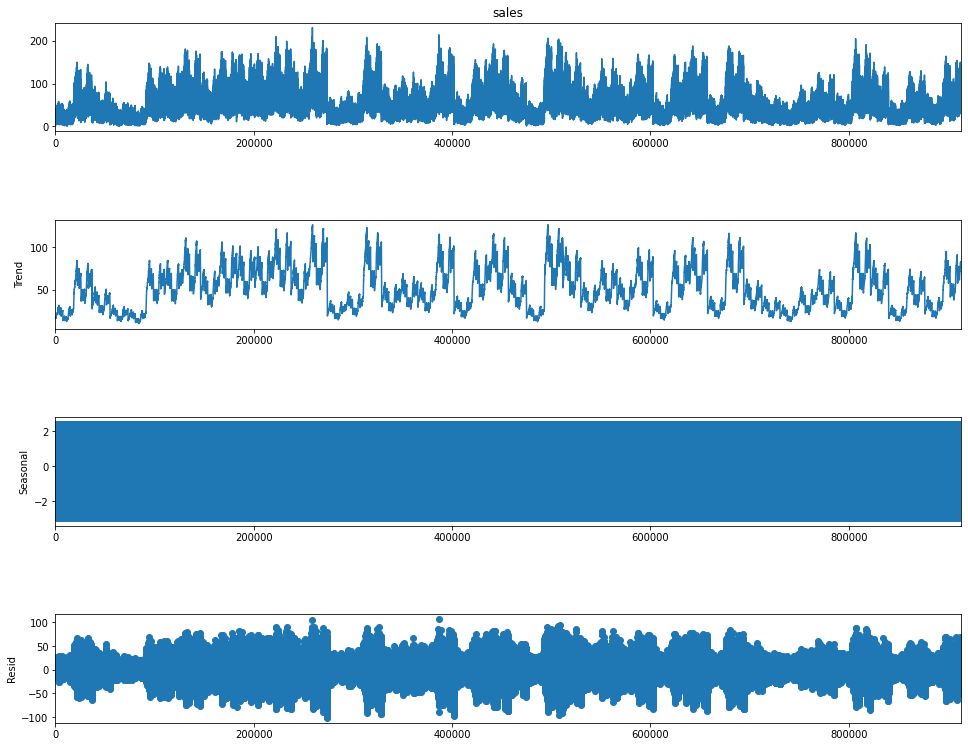

In [9]:
# Decomposition of time series
result = seasonal_decompose(x=sample, model='additive', filt=None, period=365, two_sided=False)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

#### Stationarity

If a time series is stationary and has a particular behavior over a given time interval, then it is safe to assume that it will have same behavior at some later point in time. Most statistical modeling methods assume or require the time series to be stationary.

**What is variance?**

Variance is a measurement of the spread between numbers in a data set. The variance measures how far each number in the set is from the mean. The square root of variance is the standard deviation.

**How to check Whether data is Stationary or not?**

There are two ways we can check the stationarity of a time series. The first is by looking at the data. By visualizing the data it should be easy to identify a changing mean or variation in the data. For a more accurate assessment, there is the Dickey-Fuller test. If the ‘Test Statistic’ is greater than the ‘Critical Value’ then the time series is stationary.

Implement a function which takes a timeseries as input and perform:
  * Dicky fuller test and check p-value
  * Rolling mean and rolling standard and plot it with a graph

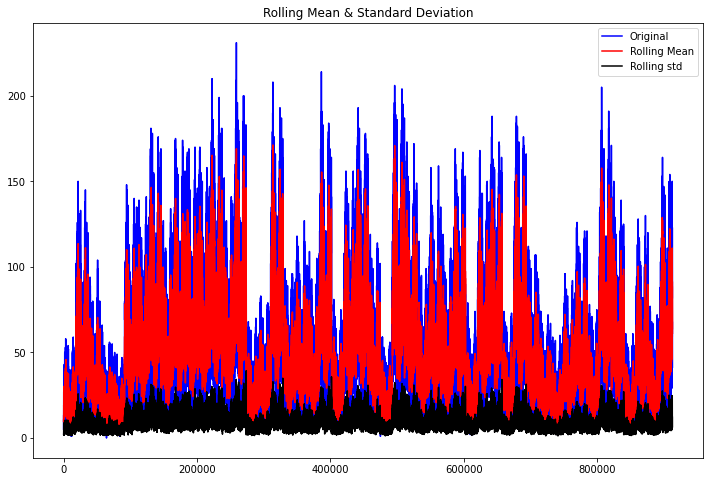

In [10]:
# Create function to test stationarity
def test_stationarity(timeseries, window = 12):

    # Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    # Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
test_stationarity(train['sales'])

Differencing the data with shift 1 and see the plot

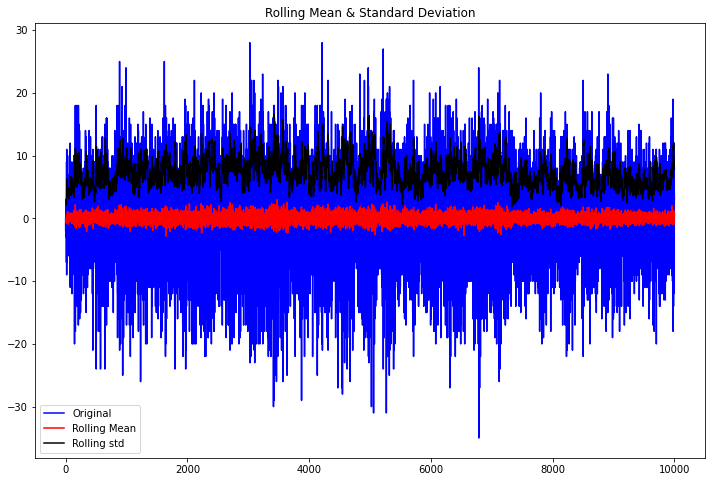

In [11]:
# differencing the data
diff = train.sales[:10000].diff(1).fillna(0)
test_stationarity(diff)

#### Dickey-Fuller test

In [12]:
# Perform Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(diff, autolag='AIC', maxlag = 20 )
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
pvalue = dftest[1]
if pvalue < 0.01:
    print('p-value = %.4f. The series is likely stationary.' % pvalue)
else:
    print('p-value = %.4f. The series is likely non-stationary.' % pvalue)

print(dfoutput)

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                  -36.415084
p-value                           0.000000
#Lags Used                       19.000000
Number of Observations Used    9980.000000
Critical Value (1%)              -3.431005
Critical Value (5%)              -2.861830
Critical Value (10%)             -2.566924
dtype: float64


### Autoregression Intuition

Consider a time series that was generated by an autoregression (AR) process with a lag of k.

We know that the ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information.

This means we would expect the ACF for the AR(k) time series to be strong to a lag of k and the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened.

We know that the PACF only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond k.

This is exactly the expectation of the ACF and PACF plots for an AR(k) process.

### Moving Average Intuition

Consider a time series that was generated by a moving average (MA) process with a lag of k.

Remember that the moving average process is an autoregression model of the time series of residual errors from prior predictions. Another way to think about the moving average model is that it corrects future forecasts based on errors made in recent forecasts.

We would expect the ACF for the MA(k) process to show a strong correlation with recent values up to the lag of k, then a sharp decline to low or no correlation. By definition, this is how the process was generated.

For the PACF, we would expect the plot to show a strong relationship to the lag and a trailing off of correlation from the lag onwards.

Again, this is exactly the expectation of the ACF and PACF plots for an MA(k) process.

**Summary:** 
From the autocorrelation plot we can tell whether or not we need to add MA terms. From the partial autocorrelation plot, we know we need to add AR terms.

References:
https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

### How to interpret ACF and PACF plots

For time series models such as Auto Regression (AR), Moving Averages (MA), or their combinations (ARMA), we need to specify one or more parameters (eg. p, q). These can be obtained by looking at ACF (to infer q parameter) and PACF (to infer p parameter) plots.

In a nutshell:

* If the ACF plot declines gradually and the PACF drops instantly, use Auto Regressive model 
* If the ACF plot drops instantly and the PACF declines gradually, use Moving Average model 
* If both ACF and PACF decline gradually, combine Auto Regressive and Moving Average models (ARMA).


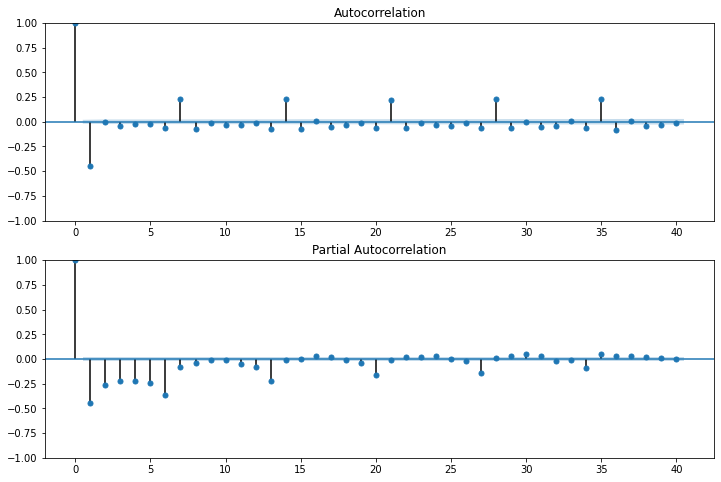

In [28]:
# Visualize ACF and PACF plots
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train.sales[:10000].diff(1).fillna(0), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train.sales[:10000].diff(1).fillna(0), lags=40, ax=ax2)

Create and fit the ARIMA model:

To know more about ARIMA click [here](https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMA.html)

In [22]:
arima_mod6 = sm.tsa.ARIMA(train.sales[:10000], order=(8,1,1)).fit(start_params=None)

In [23]:
arima_mod6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                10000
Model:                 ARIMA(8, 1, 1)   Log Likelihood              -31180.797
Date:                Fri, 18 Mar 2022   AIC                          62381.593
Time:                        13:20:21   BIC                          62453.696
Sample:                             0   HQIC                         62406.000
                              - 10000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0365      0.016      2.354      0.019       0.006       0.067
ar.L2         -0.0176      0.015     -1.173      0.241      -0.047       0.012
ar.L3         -0.0724      0.014     -5.013      0.000      -0.101      -0.044
ar.L4         -0.0552      0.014     -3.838      0.000      -0.083      -0.027
ar.L5         -0.0294      0.014     -2.121      0.034      -0.057      -0.002
ar.L6          0.0307      0.013      2.315      0.021       0.005       0.057
ar.L7          0.2491      0.012     20.174      0.000       0.225       0.273
ar.L8          0.0164      0.011      1.553      0.120      -0.004       0.037
ma.L1         -0.9118      0.012    -73.698      0.000      -0.936      -0.888
sigma2        29.9246      0.387     77.355      0.000      29.166      30.683
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               127.29
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The summary attribute that results from the output of ARIMA returns a significant amount of information, 

* The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. 
* The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

Reading ACF and PACF plots is however still challenging, and using grid search to find optimal parameter values is sometimes useful. From grid search, we can obtain an optimal parameter combination that has the lowest error (such as MAPE) or lowest general quality estimator (such as AIC).


### Identifying optimal parameters using `auto_arima`

pmdarima‘s `auto_arima` function is extremely useful when building an ARIMA model as it helps us identify the most optimal p,d,q parameters and return a fitted ARIMA model.

**Using pmdarima for Auto ARIMA model:**

In the previous method, checking for stationarity, making data stationary if necessary, and determining the values of p and q using the ACF/PACF plots can be time-consuming and less efficient. Using pmdarima’s auto_arima() function makes this task easier for us by eliminating steps for implementing an ARIMA model.


#### auto_arima

The auto-ARIMA process seeks to identify the most optimal parameters for an ARIMA model, settling on a single fitted ARIMA model.

Auto-ARIMA works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto-ARIMA also seeks to identify the optimal P and Q hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D.

In order to find the best model, auto-ARIMA optimizes for a given information_criterion, one of (‘aic’, ‘aicc’, ‘bic’, ‘hqic’, ‘oob’) (Akaike Information Criterion, Corrected Akaike Information Criterion, Bayesian Information Criterion, Hannan-Quinn Information Criterion, or “out of bag”–for validation scoring–respectively) and returns the ARIMA which minimizes the value.

**Note:** pmdarima may take a long time to find the terms for the dataset, subset of datapoints are used to minimize the execution time, however, we can experiment with a subset of the dataset.


From the ACF and PACF plot, we can observe that data is exhibiting same pattern for each 7 lags. (seasonal term 'm' = 7)

In [24]:
# Fit the model
model = pm.auto_arima(train.sales[:1000], seasonal=True, m=7) # m is seasonal term

# Make forecast
forecasts = model.predict()  # predict 1 step into the future

In [25]:
# Model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1000
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 7)   Log Likelihood               -2932.550
Date:                             Fri, 18 Mar 2022   AIC                           5879.099
Time:                                     13:25:09   BIC                           5913.446
Sample:                                          0   HQIC                          5892.154
                                            - 1000                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.651e-05      0.001      0.068      0.946      -0.002       0.002
ma.L1         -0.8906      0.031    -28.927      0.000      -0.951      -0.830
ma.L2         -0.0390      0.044     -0.889      0.374      -0.125       0.047
ma.L3          0.0342      0.031      1.104      0.270      -0.027       0.095
ar.S.L7        0.9894      0.007    148.254      0.000       0.976       1.002
ma.S.L7       -0.9280      0.020    -47.173      0.000      -0.967      -0.889
sigma2        20.4036      0.852     23.958      0.000      18.734      22.073
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 9.30
Prob(Q):                              0.93   Prob(JB):                         0.01
Heteroskedasticity (H):               1.33   Skew:                             0.07
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""